In [1]:
filename= "Y1-2colo.csv"
import pandas as pd
import numpy as np
import nltk
import re
import string
import codecs

In [2]:
url_pattern = r'((http|https)\S+)' #S= represents all non-space characters until it hits the first space
rt_pattern = r'\brt\b'
name_pattern = r'@\w+'
hashtag_pattern = r'#\w+'

def remove_extra(tweet):
    tweet = re.sub(url_pattern, ' ', tweet)
    tweet = re.sub(r'\d','',tweet)
    tweet = re.sub(rt_pattern,'', tweet)
    tweet = re.sub(name_pattern, '',tweet)
    tweet = re.sub(hashtag_pattern, '',tweet)
    return tweet 

def remove_non_ascii(tweet):
    return ''.join(i for i in tweet if ord(i) < 128)

In [3]:
from nltk.corpus import wordnet as wn
# synonym 同义词
# lemma 词条
def get_lemma(word):
    lemma = wn.morphy(word)
    #利用morphy查找不在wordnet中的词
    if lemma is None:
        return word
    else:
        return lemma

from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

en_stop = set(nltk.corpus.stopwords.words('english'))

In [4]:
#lower, punctuation, token，lemma
def prepare_text_for_lda(text):
    text = text.translate(None,string.punctuation)
    tokens = nltk.word_tokenize(text)
    #tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

In [5]:
H = []
F = []
with open(filename) as f:
    for line in f:
        parts = line.split(';')
        if len(parts) == 2:
            if len(parts[0]) > 1:
                #print parts[0]
                H.append(parts[0])
            if len(parts[1]) > 1:
                #print parts[0]
                F.append(parts[1])

HF = H + F

In [6]:
def preprocess_data(data_list):
    data = []
    for item in data_list:
        item = item.lower()
        item = remove_non_ascii(item)
        item = remove_extra(item)
        tokens = prepare_text_for_lda(item)
        if len(tokens) > 0:
            data.append(tokens)
    return data
data = preprocess_data(HF)
H_data = preprocess_data(H)
F_data = preprocess_data(F)

In [17]:
count = 0
for i in data:
    for j in i:
        count = count + 1
print count

14201


In [12]:
print data[:10]

[['hactiondesc'], [u'practice', 'drawing'], ['yeah'], ['educational', 'habbits'], ['learning', 'job', 'see', 'right'], ['argue', 'alot'], ['caring', u'rabbit', u'dog', 'next', 'year', 'take', 'farming', 'architecture', 'class'], ['better', u'organize', 'things'], ['im', 'joining', 'teamspracticinggoing', 'basketball', 'courtsand', 'working', 'hard', 'achieve'], ['im', 'traning', 'really', 'hard', 'become', 'really', 'good', 'soccer', 'player']]


In [21]:
from gensim import corpora
###For H data#####
#dictionary = corpora.Dictionary(H_data) 
#corpus = [dictionary.doc2bow(text) for text in H_data]

#######For F data#####
dictionary = corpora.Dictionary(F_data) 
corpus = [dictionary.doc2bow(text) for text in F_data]

###For all data######
#dictionary = corpora.Dictionary(F_data) 
#corpus = [dictionary.doc2bow(text) for text in F_data]

import pickle
pickle.dump(corpus,open('corpus.pkl','wb'))
#dictionary.save('dictionary.gensim')


**Calculate the coherence values**

In [8]:
import gensim

In [22]:
co_list = []
per_list = []
for i in range(1,21):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus,num_topics = i, id2word = dictionary, passes =  50)
    per = ldamodel.log_perplexity(corpus)
    per_list.append(per)
    #cohe_ldamodel = gensim.models.CoherenceModel(model = ldamodel, corpus = corpus, coherence = 'u_mass')
    cohe_ldamodel = gensim.models.CoherenceModel(model = ldamodel, texts = data, corpus = corpus, coherence = 'c_v')
    score = cohe_ldamodel.get_coherence()
    co_list.append(score)

In [23]:
print len(co_list)
print co_list

20
[0.21462011066452638, 0.37794365219977744, 0.40255373594866833, 0.4214573862371664, 0.3897565306900616, 0.4167067904249617, 0.40570290269605946, 0.35665983707383137, 0.4017803790208568, 0.44189610089138387, 0.3864791221672522, 0.41210540439362225, 0.40065285619926605, 0.42010118003680497, 0.40318005479932845, 0.38512629169363155, 0.412783531042599, 0.3786598880109675, 0.40370342577827917, 0.4145438024582783]


In [24]:
print len(per_list)
print per_list

20
[-5.530128605663776, -5.611469291711747, -5.741813444087882, -5.746900032729566, -5.8041564655192, -5.8753115425366715, -5.934889723865574, -5.942157333836606, -5.981087251744444, -5.975804008628526, -6.0075586121244555, -6.036540587087279, -6.028917067768557, -6.064114650269456, -6.1086595726886594, -6.120716945689853, -6.105456378463512, -6.133394943270176, -6.157896330784372, -6.162306512535401]


In [25]:
x = []
for i in range(1,21):
    x.append(i)
print x

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


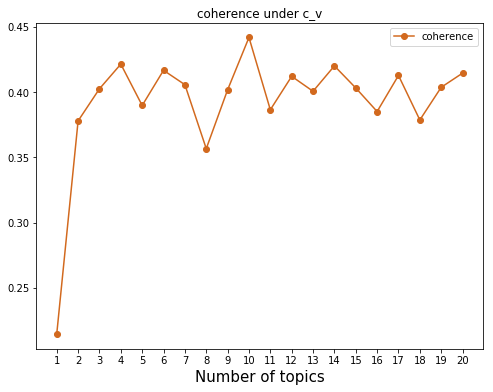

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
#plt.style.use('ggplot')
plt.figure(figsize=(8,6))

plt.plot(x,co_list, '-or', color = '#D2691E', label = 'coherence')
plt.legend()
#plt.plot(x,per_list, '-or', color = 'steelblue', label = 'coherence')
plt.xlabel('Number of topics', fontsize = 15)
plt.title('coherence under c_v')
plt.xticks(x)
#plt.savefig('coherenceforF.png')

In [30]:
import gensim
NUM_TOPICS = 10

ldamodel = gensim.models.ldamodel.LdaModel(corpus,num_topics = NUM_TOPICS, id2word = dictionary, passes = 50)
#ldamodel.save('model.gensim')


In [31]:
ldamodel.print_topics(num_words = 10)

[(0,
  u'0.070*"anything" + 0.053*"like" + 0.046*"dont" + 0.038*"job" + 0.037*"avoid" + 0.032*"im" + 0.021*"much" + 0.020*"go" + 0.015*"going" + 0.015*"ocean"'),
 (1,
  u'0.130*"school" + 0.053*"work" + 0.047*"hard" + 0.039*"going" + 0.038*"go" + 0.036*"studying" + 0.034*"job" + 0.026*"try" + 0.022*"get" + 0.020*"stay"'),
 (2,
  u'0.069*"try" + 0.057*"job" + 0.053*"nothing" + 0.040*"im" + 0.026*"learning" + 0.022*"learn" + 0.017*"things" + 0.016*"afraid" + 0.016*"help" + 0.015*"best"'),
 (3,
  u'0.148*"good" + 0.141*"grade" + 0.098*"getting" + 0.041*"get" + 0.035*"school" + 0.031*"stay" + 0.022*"away" + 0.010*"im" + 0.009*"people" + 0.009*"cook"'),
 (4,
  u'0.089*"hard" + 0.088*"working" + 0.064*"school" + 0.040*"good" + 0.038*"get" + 0.037*"grade" + 0.033*"job" + 0.028*"try" + 0.020*"im" + 0.020*"dont"'),
 (5,
  u'0.132*"get" + 0.108*"good" + 0.077*"job" + 0.070*"education" + 0.064*"try" + 0.045*"getting" + 0.026*"grade" + 0.021*"school" + 0.017*"college" + 0.017*"im"'),
 (6,
  u'0.21

In [8]:
from collections import Counter

In [19]:
def listOfList_to_counter(datas): 
    data_str = []
    for i in datas:
        for j in i:
            data_str.append(j)
    return Counter(data_str)

In [20]:
data_counter = listOfList_to_counter(data)
H_counter = listOfList_to_counter(H_data)
F_counter = listOfList_to_counter(F_data)

In [21]:
data_counter.most_common(20)

[('get', 411),
 ('school', 371),
 ('job', 340),
 ('good', 336),
 (u'try', 308),
 ('im', 307),
 (u'practice', 272),
 (u'grade', 220),
 ('hard', 176),
 ('dont', 175),
 ('getting', 163),
 ('learning', 155),
 ('help', 155),
 ('working', 138),
 ('going', 132),
 ('go', 129),
 ('want', 124),
 ('work', 121),
 ('like', 121),
 ('class', 120)]

In [22]:
H_counter.most_common(20)

[(u'practice', 260),
 ('get', 238),
 ('im', 217),
 ('school', 189),
 (u'try', 180),
 ('good', 158),
 ('help', 139),
 ('learning', 133),
 ('job', 122),
 (u'grade', 109),
 ('play', 107),
 ('class', 98),
 ('going', 86),
 ('hard', 85),
 ('make', 82),
 ('also', 82),
 ('playing', 80),
 ('better', 78),
 ('things', 78),
 ('working', 78)]

In [23]:
F_counter.most_common(20)

[('job', 218),
 ('school', 182),
 ('good', 178),
 ('get', 173),
 ('dont', 152),
 (u'try', 128),
 (u'grade', 111),
 ('hard', 91),
 ('getting', 91),
 ('im', 90),
 ('want', 72),
 ('know', 71),
 ('working', 60),
 ('education', 56),
 ('go', 52),
 ('work', 48),
 ('going', 46),
 ('avoid', 46),
 ('like', 43),
 (u'stay', 35)]